In [45]:
import sys
sys.path.insert(0, "..")

import jax
import jax.numpy as jnp

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import optax
import numpy as np
from matplotlib import pyplot as plt

In [71]:
key = jax.random.PRNGKey(0)

## Harmonic Oscillator

In this notebook we demonstrate a VMC method for finding the ground state of the 3D harmonic oscilator. The hamiltonian thus is:

$$
H = -\frac{\hbar^2 }{2 m}\Delta + \frac{1}{2}m\omega^2(x^2+y^2+z^2)
$$

The corresponding energies are known:
$$
E = \hbar \omega \left(n_x + n_y + n_z + \frac{3}{2}\right)
$$

We set $\hbar = m = \omega = 1$. The ground state energy is thus:

$$
E = \frac{3}{2} = 1.5
$$

In the code, the hamiltonian is defined as follows:

In [87]:
w = 1   # omega

#
# The potential energy function depending on the coordinates
#
def potential(x):
    return 0.5*w**2*jnp.sum(x**2, axis = -1)


# the hamiltonian
H = module.hamiltonians.Particles(masses = [1], potential = potential, d_space=3)

We use a very simple variational Ansatz:
$$
\Psi = \exp{-\frac{1}{2}r^2\lambda}
$$
using $\lambda = e^a$, $a$ being the variational parameter. The ground state is found for $a = 0$.

In [89]:
class Gaussian(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__((3,))

    def init_parameters(self, key):
        return {"a": jax.random.normal(key) + 2}

    def calc_logpsi(self, parameters, x):
        logpsi = -0.5*jnp.sum(x**2, axis = -1) * jnp.exp(parameters["a"])
        return logpsi

In [91]:
wavefun = Gaussian()
parameters = wavefun.init_parameters(key)

We also initialise a MCMC sampler for our wavefunction and can take samples of it:

In [95]:
sampler = module.samplers.MCMC(wavefun, variance = 0.3)

Using the Hamiltonian, we can already compute the expected energy for our non-optimised wavefunction:

In [99]:
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 10000)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.3049
Expected Energy: 2.703737
Std of Expected Energy: 1.8766611


To estimate the gradient of the expected energy via the formula:

$$
\nabla \left< E \right>  = 2\,\Re\, \mathbb{E}\{\nabla \log \Psi [H_{\mathrm{loc}}(r) - \mathbb{E}(E)]\}
$$

we implement a help function:

In [75]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    grad_log = orbital.grad_logpsi(parameters, samples)

    return jax.tree_util.tree_map(lambda tree: 2*jnp.real(jnp.mean(tree * (E_loc - E))), grad_log), E

The energy can now be optimised:

In [100]:
Es = []
ratios = []

In [101]:
# define
optimizer = optax.adam(learning_rate=0.01)

# initialise
optimizer_state = optimizer.init(parameters)

for i in tqdm(range(1000)):
    key, _ = jax.random.split(key)
    samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 500)
    grad, E = calc_grad_E(H, orbital, parameters, samples)

    Es.append(E)
    ratios.append(ratio)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, parameters)
    parameters = optax.apply_updates(parameters, updates)

100%|██████████| 1000/1000 [00:02<00:00, 384.85it/s]


Text(0.5, 1.0, 'Energy Optimisation')

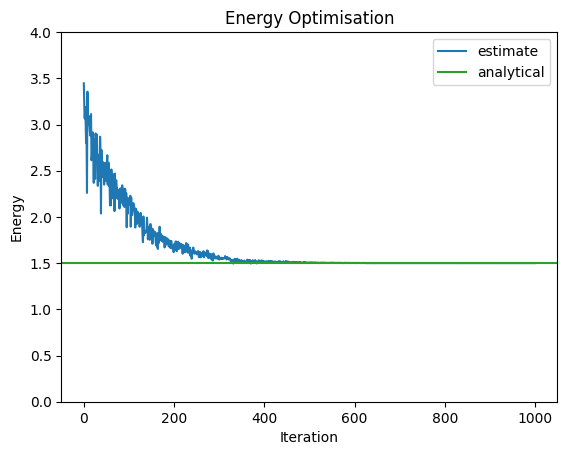

In [110]:
plt.plot(Es, label = "estimate")
plt.ylim(0,4)
plt.axhline(0.5 * w * 3, color = "C2", label = "analytical")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy Optimisation")

Now, the variance of the expected energy has decreased, as expected for correct eigenstate:

In [111]:
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 10000)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.551
Expected Energy: 1.5
Std of Expected Energy: 1.6814427e-07


---